In [2]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from tqdm.notebook import tqdm
import scipy.spatial.distance as spdists
#from curlyBrace import curlyBrace
%matplotlib inline

In [3]:
#scipy.stats uses numpy.random seed
np.random.seed(seed=0)

In [4]:
#First look at 1d for KS
rv_uniform = st.uniform()
rv_beta = st.beta(3,3)
samples1d = rv_uniform.rvs(100)
samples1d

array([0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
       0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152,
       0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606,
       0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215,
       0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443,
       0.63992102, 0.14335329, 0.94466892, 0.52184832, 0.41466194,
       0.26455561, 0.77423369, 0.45615033, 0.56843395, 0.0187898 ,
       0.6176355 , 0.61209572, 0.616934  , 0.94374808, 0.6818203 ,
       0.3595079 , 0.43703195, 0.6976312 , 0.06022547, 0.66676672,
       0.67063787, 0.21038256, 0.1289263 , 0.31542835, 0.36371077,
       0.57019677, 0.43860151, 0.98837384, 0.10204481, 0.20887676,
       0.16130952, 0.65310833, 0.2532916 , 0.46631077, 0.24442559,
       0.15896958, 0.11037514, 0.65632959, 0.13818295, 0.19658236,
       0.36872517, 0.82099323, 0.09710128, 0.83794491, 0.09609841,
       0.97645947, 0.4686512 , 0.97676109, 0.60484552, 0.73926

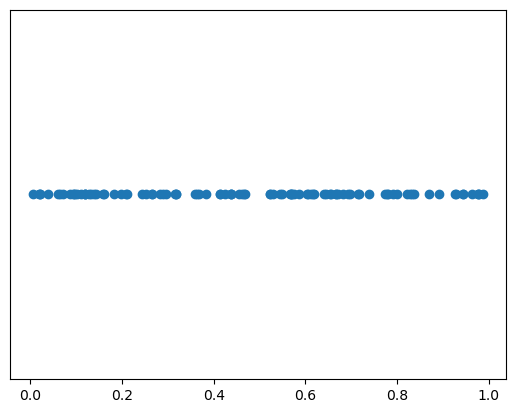

In [5]:
f,ax = plt.subplots()
ax.scatter(samples1d, [0]*len(samples1d))
ax.ylabel = None
ax.set_yticklabels([])
ax.tick_params(left=False)
plt.show()

In [6]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

Text(0.7163272041185655, 0.79, '')

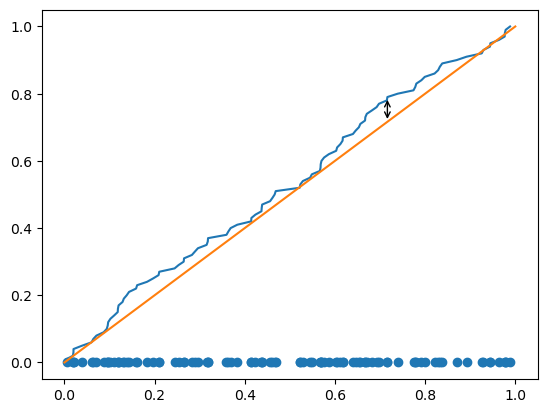

In [7]:
Fx, Fy = ecdf(samples1d)
supidx = np.argmax(Fy-Fx)
f,ax = plt.subplots()
ax.scatter(samples1d, [0]*len(samples1d))
ax.plot(Fx, Fy)
ax.plot([0,1],[0,1])
ax.annotate("", xy=(Fx[supidx],Fx[supidx]), xytext=(Fx[supidx],Fy[supidx]), arrowprops=dict(arrowstyle='<->',color="black"))


In [8]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values

In [9]:
def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in tqdm(data):
        ec = sampled_ecc_alpha(dat, n_samples, max_filt_val)
        eccs.append(ec)
    return eccs

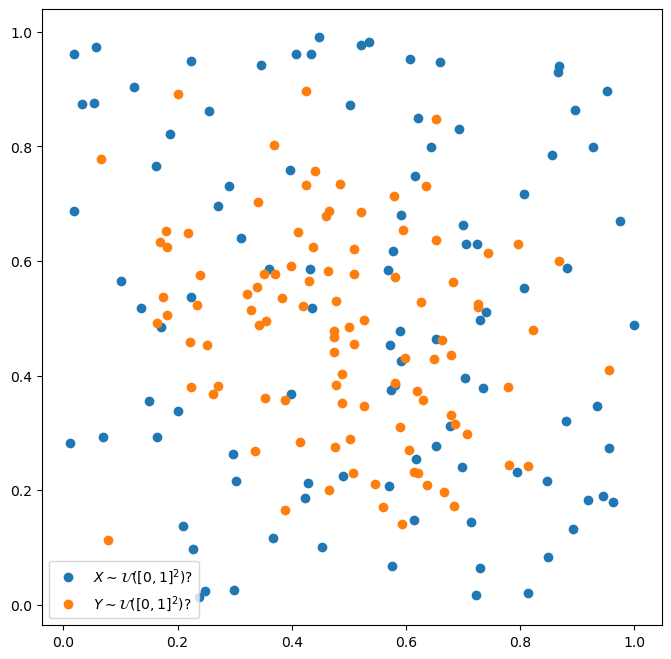

In [10]:
#Now in 2d for ECC test


n=100
n_loops = 1000
d = 2
steps = 1001
maxfilt = 3
radii = np.linspace(0,maxfilt,steps)
samplesUxU = np.array([rv_uniform.rvs(n), rv_uniform.rvs(n)]).T
samplesBxB = np.array([rv_beta.rvs(n), rv_beta.rvs(n)]).T

ecUxU = sampled_ecc_alpha(n**(1/2)*samplesUxU, steps,maxfilt)
ecBxB = sampled_ecc_alpha(n**(1/2)*samplesBxB, steps,maxfilt)


f,ax1= plt.subplots(1,1, figsize = (8,8))
ax1.scatter(samplesUxU[:,0], samplesUxU[:,1], label ="$X\sim \mathcal{U}([0,1]^2)?$", color="tab:blue")
ax1.legend()
plt.savefig("unif-square-n100.pdf")

ax1.scatter(samplesBxB[:,0], samplesBxB[:,1], label ="$Y\sim \mathcal{U}([0,1]^2)?$", color="tab:orange")
ax1.legend()
plt.savefig("unif-vs-beta33-square-n100.pdf")




plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

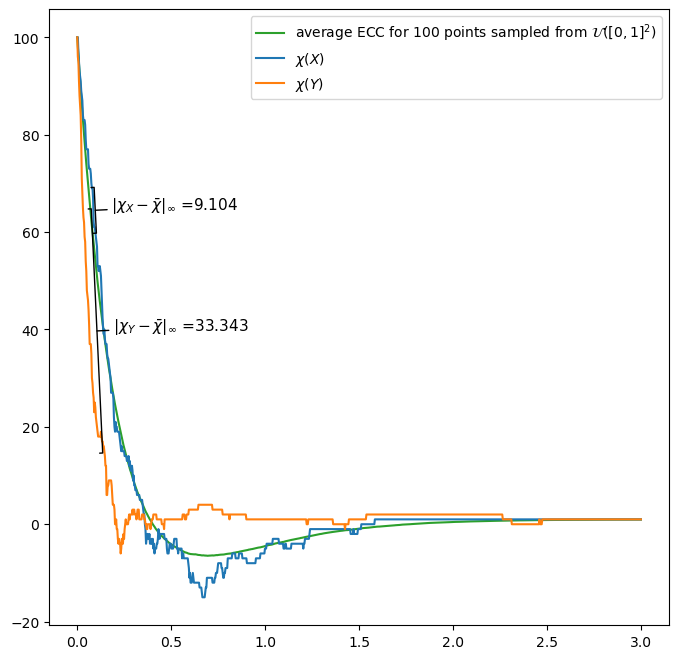

In [11]:
radii = np.linspace(0,maxfilt,steps)

samplesUxU = [n**(1/2)*np.array([rv_uniform.rvs(n), rv_uniform.rvs(n)]).T for i in range(0,n_loops)]
eccs_UxU = get_ecc(samplesUxU, steps,maxfilt)
ecc_mean = np.mean(eccs_UxU, axis = 0)
supdistU = np.max(np.abs(ecc_mean - ecUxU))
suparg = np.argmax(np.abs(ecc_mean - ecUxU))

f,ax = plt.subplots(figsize = (8,8))
ax.plot(radii,ecc_mean, label = "average ECC for 100 points sampled from $\mathcal{U}([0,1]^2)$", color="tab:green")
ax.plot(radii, ecUxU, label = "$\chi(X)$", color="tab:blue")

ax.annotate("$\|\chi_X-\\bar{\chi}\|_{\infty}$ ="+str(supdistU), fontsize = "11",xy=(radii[suparg],0.5*(ecUxU[suparg]+ecc_mean[suparg])),xycoords="data",xytext = (radii[suparg]+0.1,0.5*(ecUxU[suparg]+ecc_mean[suparg])),textcoords="data",arrowprops={"arrowstyle":"-[, widthB=1.5", "connectionstyle":"arc3","shrinkA":1,"shrinkB":2, "color":"black"})
ax.legend()
plt.savefig("ECC-unif-n100-supdist.pdf")
ax.plot(radii, ecBxB, label = "$\chi(Y)$", color="tab:orange")
supdistB = np.max(np.abs(ecc_mean - ecBxB))
suparg = np.argmax(np.abs(ecc_mean - ecBxB))
ax.annotate("$\|\chi_Y-\\bar{\chi}\|_{\infty}$ ="+str(supdistB), fontsize = "11",xy=(radii[suparg],0.5*(ecBxB[suparg]+ecc_mean[suparg])),xycoords="data",xytext = (radii[suparg]+0.1,0.5*(ecBxB[suparg]+ecc_mean[suparg])),textcoords="data",arrowprops={"arrowstyle":"-[, widthB=8", "connectionstyle":"arc3","shrinkA":1,"shrinkB":2, "color":"black"})
ax.legend()
plt.savefig("ECC-unif-vs-beta33-n100-supdist.pdf")
plt.show()

In [12]:
#compute pvals
samplesUxU = [n**(1/2)*np.array([rv_uniform.rvs(n), rv_uniform.rvs(n)]).T for i in range(0,n_loops)]
eccs_UxU = get_ecc(samplesUxU, steps,maxfilt)
Deltas = np.array([np.max(np.abs(ecc_mean-eccs_UxU[i])) for i in range(0,len(samplesUxU))])
print("PV uniform", np.mean(Deltas > supdistU))
print("PV beta", np.mean(Deltas > supdistB))


  0%|          | 0/1000 [00:00<?, ?it/s]

PV uniform 0.42
PV beta 0.0
